In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Clinical Data

## Load and check clinical data

First I load and check the data, to make sure of the following:
- there are one line per patient (no duplicates),
- there are no missing start date and the date are in a good format,
- there are no missing treatment follow-up, stop boolean or treatment flag.

Then I print the percentage of missing data for the variables at baseline. 

In [64]:
# Load data
df_clinical = pd.read_csv('_data/clinical.csv').set_index('pnr')

# Data quality checks
assert len(df_clinical.index.unique()) == len(df_clinical) # One line per patient

# Start date
assert len(df_clinical[df_clinical["start"].isna()]) == 0 # No missing date
df_clinical["start"] = pd.to_datetime(df_clinical["start"]) # No error raise on date format

# Treatment follow-up
assert len(df_clinical[df_clinical["fu_trt"].isna()]) == 0 # No follow-up 
assert len(df_clinical[df_clinical["stopped_trt"].isna()]) == 0 # No boolean
assert len(df_clinical[df_clinical["drug"].isna()]) == 0 # No unknown treatment

print(round(100*df_clinical[['crp', 'pain', 'tjc', 'sjc']].isna().sum()/len(df_clinical)))


crp     18.0
pain    24.0
tjc     19.0
sjc     19.0
dtype: float64


## Study design statistics

The I print some statistics about the data: the number of patients, the date of the study and the population for both treatments. 

In [65]:
# Key stats

# Patients
print(f"{len(df_clinical)} patients")
print(f"Recruited between {df_clinical['start'].min()} and {df_clinical['start'].max()}")

# Drug repartition
percent_A = round(len(df_clinical[df_clinical['drug']=="A"])/len(df_clinical)*100)
percent_B = round(len(df_clinical[df_clinical['drug']=="B"])/len(df_clinical)*100)
print(f"Treatments: A {len(df_clinical[df_clinical['drug']=='A'])} patients ({percent_A}%), B {len(df_clinical[df_clinical['drug']=='B'])} patients ({percent_B}%)")

1185 patients
Recruited between 2010-01-05 00:00:00 and 2016-12-27 00:00:00
Treatments: A 687 patients (58%), B 498 patients (42%)


Then I wanted to know more about the censoring process: is it a study of a given length or a study between two dates? 

In [66]:
# End of follow-up
df_clinical['stop'] = df_clinical['start'] + pd.to_timedelta((df_clinical['fu_trt']*30), unit = 'D') # Approximative handling of time delta

print(f"Date of censure vary from {df_clinical[df_clinical['stopped_trt'] == 0]['stop'].min()} to {df_clinical[df_clinical['stopped_trt'] == 0]['stop'].max()}")
print(f"Time of follow-up for censure vary from  {df_clinical[df_clinical['stopped_trt'] == 0]['fu_trt'].min()} to {df_clinical[df_clinical['stopped_trt'] == 0]['fu_trt'].max()} months")

Date of censure vary from 2010-06-21 23:59:59.999913600 to 2018-01-31 00:00:00.000864008
Time of follow-up for censure vary from  3.3 to 60.0 months


It seems that there are neither a clear censoring date nor a max follow-up ... Thus there might be some informative censoring. In an ideal world I would discuss with clinician or the person who design the study or look for references associated to the data, to better understand recruitment process. Here, as there are no further information, I will assume in the following analysis that the censoring is at random, but this hypothesis could be discussed.  


## Clinical data analysis

Then I compare the distribution of the variable at baseline for the different treatment, also looking at missing values. 

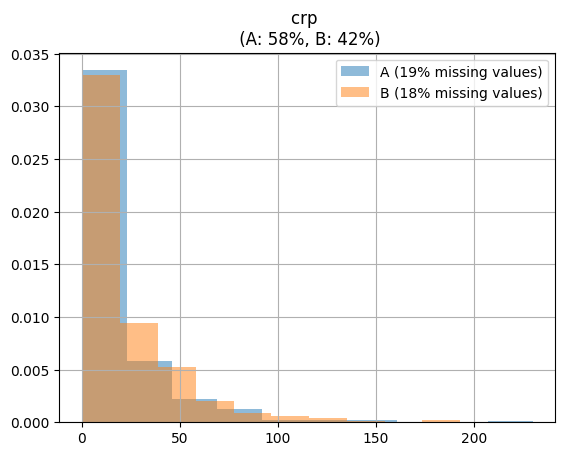

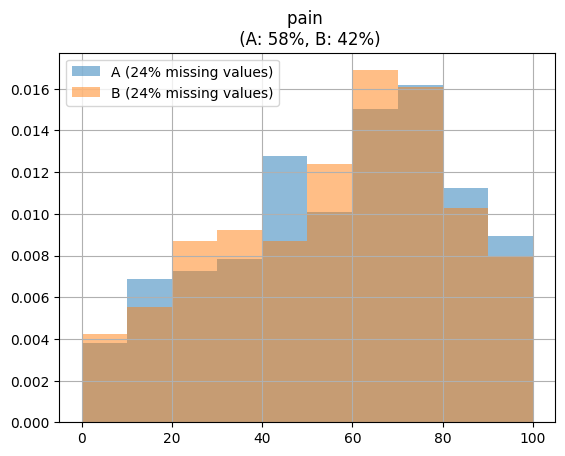

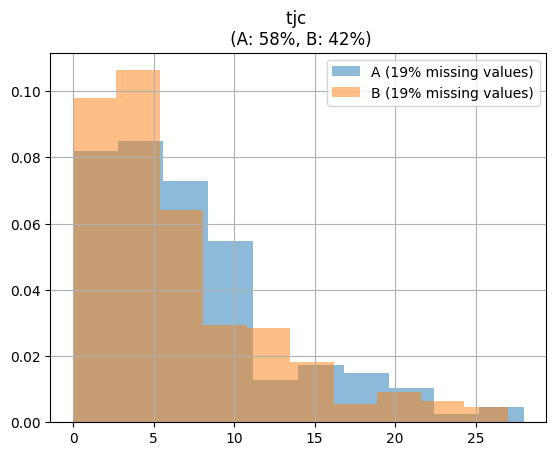

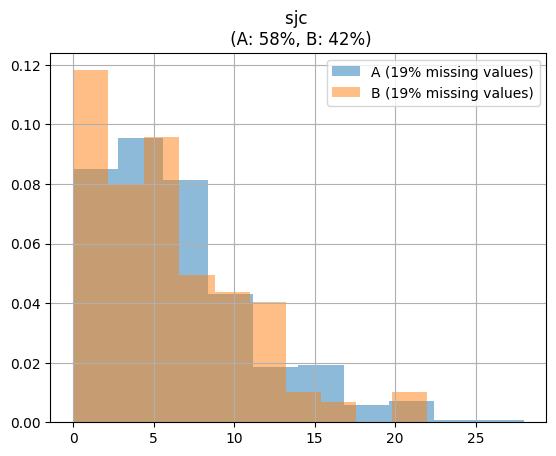

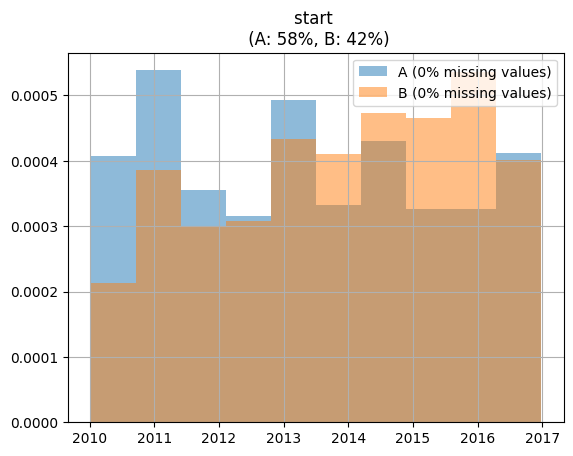

In [67]:
for col_baseline in ['crp', 'pain', 'tjc', 'sjc', 'start']:
    for drug, color in zip(["A", "B"], ["blue", "orange"]):
        df_plot = df_clinical[df_clinical['drug']==drug]
        perc_missing = round(100*df_plot[col_baseline].isna().sum()/len(df_plot))
        df_plot[col_baseline].hist(density = True, alpha = 0.5,
                                   label = f"{drug} ({perc_missing}% missing values)")
    plt.title(f"{col_baseline} \n (A: {percent_A}%, B: {percent_B}%)")
    plt.legend()
    plt.show()

At a first glance, patients characteristics do not seem really different comparing the two treatments, even if some testing would be needed to better characterize it. Nevertheless, in terms of incidence of treatment use, there seems to be differences. Maybe treatment B was introduced later than treatment A, that would be something to discuss with experts or to look in literature, and further analyze it. 

Then, I have checked for time to treatment interruption. As the interruption can be censored in the database, I used a Kaplan Meier, assuming censoring was not informative, but this hypothesis could be discussed given the recruitment process. 

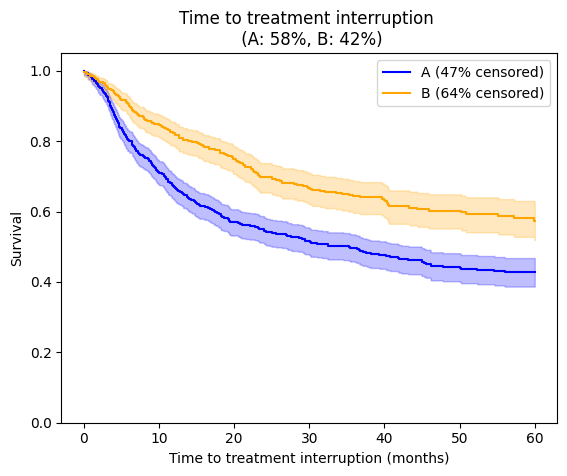

In [68]:
for drug, color in zip(["A", "B"], ["blue", "orange"]):
    df_plot = df_clinical[df_clinical['drug']==drug]
    percent_pop = round(len(df_plot)/len(df_clinical)*100)
    censoring_rate = round((1 - df_plot['stopped_trt'].sum()/len(df_plot))*100)
    kmf = KaplanMeierFitter(label=f"{drug} ({censoring_rate}% censored)")
    kmf.fit(df_plot['fu_trt'], df_plot['stopped_trt'])
    kmf.plot(color = color)
plt.xlabel('Time to treatment interruption (months)')
plt.ylabel('Survival')
plt.title(f'Time to treatment interruption \n (A: {percent_A}%, B: {percent_B}%)')
plt.ylim(0,1.05)
plt.show()

# Patients historic

## Load and check data indatum

For the inpatients (patients that can stay several days), I check the following: 
- that there were no missing date nor bad format for both admission and leave,
- the duplicated raw, it seems that a patients can have several visits in one day and several visits in one day with the same main diagnosis. As it was further state in the assignment to "Count each out- and inpatient visit, even if recorded on the same date." I did not clean duplicates. 
- I checked that the main diagnosis could not be missing and then the percentage of the missing information for other diagnosis. 
- I checked if the first diagnosis was the same as the main diagnosis. 

In [69]:
df_inpatient = pd.read_csv('_data/inpatient.csv')

# Start date
assert len(df_inpatient[df_inpatient["indatum"].isna()]) == 0 # No missing date
df_inpatient["indatum"] = pd.to_datetime(df_inpatient["indatum"]) # No error raise on date format

# End date date
assert len(df_inpatient[df_inpatient["utdatum"].isna()]) == 0 # No missing date
df_inpatient["utdatum"] = pd.to_datetime(df_inpatient["utdatum"]) # No error raise on date format

# Clean dupplicates
print(f"{len(df_inpatient[df_inpatient.set_index(['pnr', 'indatum']).index.duplicated()])} visits duplicated with (pnr, indatum) as key")
print(f"{len(df_inpatient[df_inpatient.set_index(['pnr', 'indatum', 'HDIA']).index.duplicated()])} visits duplicated with (pnr, indatum, HDIA) as key")
df_inpatient = df_inpatient.set_index('pnr')

# Missing data and diagnosis
assert len(df_inpatient[df_inpatient["HDIA"].isna()]) == 0 # No missing date
print(round(100*df_inpatient.isna().sum()/len(df_inpatient)))
print(f"For {len(df_inpatient[df_inpatient['DIA01']!=df_inpatient['HDIA']])} visits the HDIA was not the DIA01, but the DIA02")

66 visits duplicated with (pnr, indatum) as key
29 visits duplicated with (pnr, indatum, HDIA) as key
HDIA        0.0
DIA01       0.0
DIA02      35.0
DIA03      57.0
DIA04      72.0
DIA05      82.0
DIA06      89.0
indatum     0.0
utdatum     0.0
dtype: float64
For 12 visits the HDIA was not the DIA01, but the DIA02


## Load and check data outdatum

I made the same checks for the outpatients. 

In [70]:
df_outpatient = pd.read_csv('_data/outpatient.csv')

# Start date
assert len(df_outpatient[df_outpatient["indatum"].isna()]) == 0 # No missing date
df_outpatient["indatum"] = pd.to_datetime(df_outpatient["indatum"]) # No error raise on date format

# Clean duplicates
print(f"{len(df_outpatient[df_outpatient.set_index(['pnr', 'indatum']).index.duplicated()])} visits duplicated with (pnr, indatum) as key")
print(f"{len(df_outpatient[df_outpatient.set_index(['pnr', 'indatum', 'HDIA']).index.duplicated()])} visits duplicated with (pnr, indatum, HDIA) as key")
df_outpatient = df_outpatient.set_index('pnr')

# Missing data and diagnosis
assert len(df_outpatient[df_outpatient["HDIA"].isna()]) == 0 # No missing date
print(round(100*df_outpatient.isna().sum()/len(df_outpatient)))
print(f"For {len(df_outpatient[df_outpatient['DIA01']!=df_outpatient['HDIA']])} visits the HDIA was not the DIA01, but the DIA02")

1497 visits duplicated with (pnr, indatum) as key
713 visits duplicated with (pnr, indatum, HDIA) as key
HDIA         0.0
DIA01        0.0
DIA02       81.0
DIA03       95.0
DIA04       98.0
DIA05       99.0
DIA06      100.0
indatum      0.0
dtype: float64
For 206 visits the HDIA was not the DIA01, but the DIA02


# Study statistics

Like for clinical data, I check the recruitment dates and the number of patients and visits. 

In [71]:
# Key stats

# Inpatients
print(f"{len(df_inpatient.index.unique())} inpatients with at least one visits")
print(f"{len(df_inpatient)} inpatients visits")
print(f"{round(df_inpatient.groupby('pnr').count()['HDIA'].mean(),1)} +/- {round(df_inpatient.groupby('pnr').count()['HDIA'].std(),1)} visits per patient")
print(f"Inpatients recruited between {df_inpatient['indatum'].min()} and {df_inpatient['utdatum'].max()}")
print("\n")

# Outpatients
print(f"{len(df_outpatient.index.unique())} outpatients with at least one visits")
print(f"{len(df_outpatient)} outpatients visits")
print(f"{round(df_outpatient.groupby('pnr').count()['HDIA'].mean(),1)} +/- {round(df_outpatient.groupby('pnr').count()['HDIA'].std(),1)} visits per patient")
print(f"Inpatients recruited between {df_outpatient['indatum'].min()} and {df_outpatient['indatum'].max()}")


1023 inpatients with at least one visits
5622 inpatients visits
5.5 +/- 6.0 visits per patient
Inpatients recruited between 1997-01-09 00:00:00 and 2016-12-30 00:00:00


1249 outpatients with at least one visits
65269 outpatients visits
52.3 +/- 39.7 visits per patient
Inpatients recruited between 2001-01-02 00:00:00 and 2016-12-31 00:00:00


The outpatient base start later, as it was created later [[ref](https://www.socialstyrelsen.se/en/statistics-and-data/registers/national-patient-register/)].

# Diagnosis frequency 

Diagnosis are coded using the ICD10 codes. To group a bit diagnosis I used only the first 3 characters, of the code. Then I checked what were the most frequent diagnosis, keeping a threshold of frequency above 3%.

In [72]:
def extract_three_character_ICD10(x):
    """
    Extract the first three character from the ICD10 code if its not nan.

    Args:
        x (string or np.nan): ICD10 code

    Returns:
        _type_: first three characters from the code if it is not nan
    """
    if not pd.isna(x):
        return x[:3]
    else:
        x

In [73]:
list_in_out = []
for name, df_study in zip(['inpatient', 'outpatient'], [df_inpatient, df_outpatient]):
    list_diag = []
    for col_diag in ['HDIA', 'DIA02', 'DIA03', 'DIA04', 'DIA05', 'DIA06', 'HDIA']: # not DIA01 as its mainly as HDIA
        
        label_freq = df_study[col_diag].apply(extract_three_character_ICD10).value_counts()
        label_freq = round(100*label_freq/len(df_study))
        label_freq = label_freq[label_freq>=3].to_frame() # keep diagnosis with frequency above 3%
        label_freq.columns = [col_diag]
        list_diag.append(label_freq)

    df_diag = pd.concat(list_diag, axis = 1).fillna('-')
    df_diag.columns = pd.MultiIndex.from_product([[name], df_diag.columns ])
    list_in_out.append(df_diag)

pd.concat(list_in_out, axis = 1).fillna('-')

inpatient                                     outpatient              \
         HDIA DIA02 DIA03 DIA04 DIA05 DIA06  HDIA       HDIA DIA02 DIA03   
M05      10.0   7.0   4.0     -     -     -  10.0       40.0     -     -   
M06       4.0   6.0   4.0     -     -     -   4.0        9.0     -     -   
O80       3.0     -     -     -     -     -   3.0          -     -     -   
I10         -   5.0   4.0   3.0     -     -     -          -     -     -   

                             
    DIA04 DIA05 DIA06  HDIA  
M05     -     -     -  40.0  
M06     -     -     -   9.0  
O80     -     -     -     -  
I10     -     -     -     -

This tab present the first three characters of ICD10 code for each type of diagnosis that appear more than 3% of the time, associated with there frequency. Using this [reference](https://icd.who.int/browse10/2019/en) I try to understand what they could be related to:
- M05: Seropositive rheumatoid arthritis
- M06: Other rheumatoid arthritis
- O80: Single spontaneous delivery
- I10: Essential (primary) hypertension

Here, rheumatoid diagnosis are the most frequent diagnosis, I guess that an extraction of the database was made to try to sub-select almost only the patients Swedish Rheumatology Quality of Care Register which can explain that the rheumatoid diagnosis is the most frequent main diagnosis. We can also note that some diagnosis such as hypertension (I10) are mainly given as secondary diagnosis. 

# Database over time

Then I checked how the number of visits change over time. 

In [74]:
id_clinical = df_clinical.index.unique()
id_inpatient = df_inpatient.index.unique()
id_outpatient = df_outpatient.index.unique()

print(f"{round(100*len(list(set(id_clinical) & set(id_inpatient)))/len(id_clinical))}% of patients in the clinical database are in inpatient ")
print(f"{round(100*len(list(set(id_clinical) & set(id_inpatient)))/len(id_inpatient))}% of patients in inpatients are in the clinical database")

print("\n")

print(f"{round(100*len(list(set(id_clinical) & set(id_outpatient)))/len(id_clinical))}% of patients in the clinical database are in outpatient ")
print(f"{round(100*len(list(set(id_clinical) & set(id_outpatient)))/len(id_outpatient))}% of patients in outpatients are in the clinical database")

82% of patients in the clinical database are in inpatient 
95% of patients in inpatients are in the clinical database


100% of patients in the clinical database are in outpatient 
95% of patients in outpatients are in the clinical database


The different databases do not contain exactly the same patients but almost. 

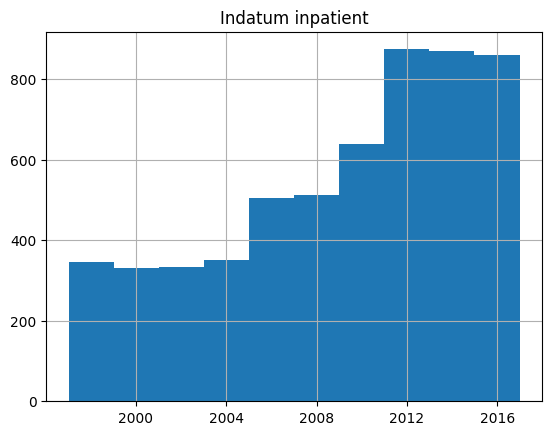

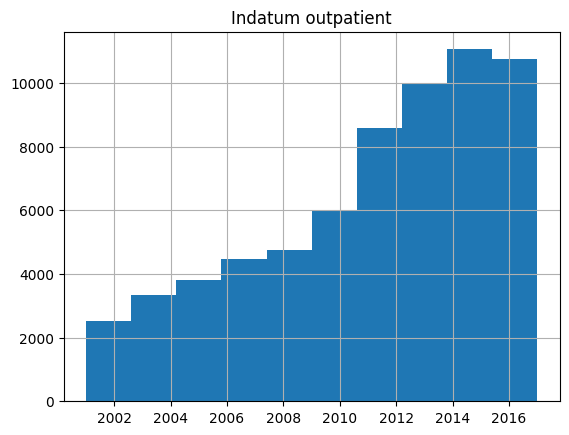

In [75]:
# Inpatients
df_inpatient['indatum'].hist()
plt.title('Indatum inpatient')
plt.show()

# Outpatients
df_outpatient['indatum'].hist()
plt.title('Indatum outpatient')
plt.show()

The number of visits is clearly increasing with time. This might be linked to the extraction that seems to follow patients from the Swedish Rheumatology Quality of Care Register between 2010 and 2016. As the first patients recruited continue aging this can explain the increasing number of visits selected with time.

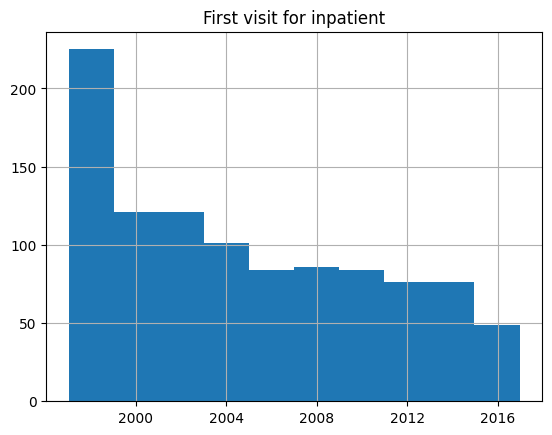

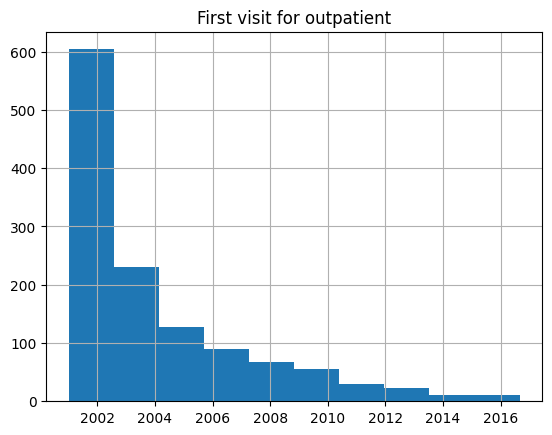

In [77]:
df_inpatient.groupby('pnr')['indatum'].min().hist()
plt.title('First visit for inpatient')
plt.show()

df_outpatient.groupby('pnr')['indatum'].min().hist()
plt.title('First visit for outpatient')
plt.show()


The first date of appearance of a patient in each database is clearly influenced by the date of creation of the database. This is something to keep in mind when joining the bases. 

# Conclusion

The Swedish Rheumatology Quality of Care Register contain quite a lot of patients 1,185 with treatments choice and follow-up. Some covariates are missing with rates around 20%. Treatments are quite equilibrate (58% A, 42% B), and seems to have quite the same covariates distribution. Yet, I got the impression that B was used more and more as time pass, that would be something to further discuss with expert or investigate. 


The National Patient Register for both outpatient and inpatient parts, contain almost the same patients as in the Swedish Rheumatology Quality of Care Register. As expected there are less inpatient visits. The two databases were not started at the same time, which should also be taken into account. Finally, patients were recruited almost 10 years after the creation of the last register, yet caution should be taken when joining the database to not introduce bias as early recruited patient will have less information before recruitment but more after. 